In [2]:
df = pd.read_pickle('df_ventas_filtrado.pkl')

In [3]:
df.columns

Index(['Marca', 'Modelo', 'Version', 'Precio', 'Precio_financiado',
       'Combustible', 'Anyo', 'Kilometros', 'Potencia', 'Vendedor_profesional',
       'Vendedor', 'Provincia', 'Comunidad_Autonoma'],
      dtype='object')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.graphics.gofplots import qqplot
from scipy import stats


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41464 entries, 1 to 49999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Marca                 41464 non-null  object 
 1   Modelo                41464 non-null  object 
 2   Version               41464 non-null  object 
 3   Precio                41464 non-null  int64  
 4   Precio_financiado     41464 non-null  float64
 5   Combustible           41464 non-null  object 
 6   Anyo                  41464 non-null  float64
 7   Kilometros            41464 non-null  int64  
 8   Potencia              41464 non-null  float64
 9   Vendedor_profesional  41464 non-null  bool   
 10  Vendedor              41464 non-null  object 
 11  Provincia             41464 non-null  object 
 12  Comunidad_Autonoma    41464 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 4.2+ MB


Cambios el tipo de dato de las variables Anyo y Vendedor_profesional ya que tienen tipo ``int64`` y ``bool`` respectivamente, pero son variables categóricas

In [7]:
df.Anyo = df.Anyo.astype(str)
df.Vendedor_profesional = df.Vendedor_profesional.astype(str)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41464 entries, 1 to 49999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Marca                 41464 non-null  object 
 1   Modelo                41464 non-null  object 
 2   Version               41464 non-null  object 
 3   Precio                41464 non-null  int64  
 4   Precio_financiado     41464 non-null  float64
 5   Combustible           41464 non-null  object 
 6   Anyo                  41464 non-null  object 
 7   Kilometros            41464 non-null  int64  
 8   Potencia              41464 non-null  float64
 9   Vendedor_profesional  41464 non-null  object 
 10  Vendedor              41464 non-null  object 
 11  Provincia             41464 non-null  object 
 12  Comunidad_Autonoma    41464 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 4.4+ MB


Primero comprobamos el tipo de distribución que tiene la variable precio

<AxesSubplot:xlabel='Precio', ylabel='Count'>

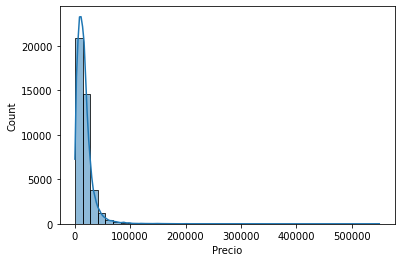

In [9]:
sns.histplot(data=df, x="Precio", bins=40, kde=True)

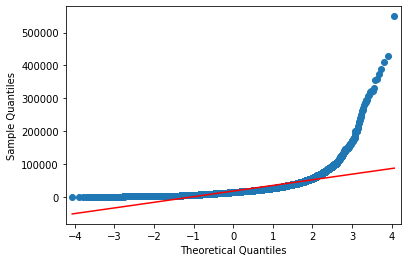

In [10]:
qqplot(df.Precio , line='s');


En las gráficas podemos ver que la distribución no parece normal,\
para segurarlo de manera estadistica, vamos a aplicar el normaltest de scipy

$$ H_0 = \text{La distribución es normal}\\
H_1 = \text{La distribución no es normal} $$

In [11]:
stat, p_value =stats.normaltest(df.Precio)
if p_value > 0.05:
    print(
        f'p_value = {p_value}. Se acepta la hipótesis nula --> tenemos una distribución normal')
else:
    print(
        f'p_value = {p_value}. Se rechaza la hipótesis nula --> no tenemos una distribución normal')

p_value = 0.0. Se rechaza la hipótesis nula --> no tenemos una distribución normal


## Para poder realizar unmejor análisis de las diferentes variables vamos a identificar los outliers y eliminarlos en caso de que lo consideremos oportuno.

La siguiente funcion nos caluculará el número de outliers de cada columna (numérica) y nos indicará los limites a partir de los cuales podremos eliminar los valores

In [12]:
def outliers(df):
        df_num = df.select_dtypes(exclude=['object','boolean'])
        dic = pd.DataFrame()
        for i in df_num.columns:
                Q_1 = df_num[i].quantile(0.25)
                Q_3 = df_num[i].quantile(0.75)
                RI = Q_3 - Q_1
                lim_inf = Q_1 - 1.5*RI
                lim_sup = Q_3 + 1.5*RI
                outliers = df_num[(df_num[i] < lim_inf) | (df_num[i] > lim_sup )].shape[0]
                dic[i] = [outliers,lim_inf,lim_sup]
                print(f'{i} : {outliers}')
        dic.index = ['num_outliers','valor_min','valor_max']
        return dic

In [13]:
outliers_df = outliers(df)

Precio : 2048
Precio_financiado : 1081
Kilometros : 528
Potencia : 3275


In [14]:
outliers_df

,Precio,Precio_financiado,Kilometros,Potencia
num_outliers,2048.000,1081.0,528.0,3275.0
valor_min,-12474.125,-25050.0,-145500.0,28.0
valor_max,42120.875,41750.0,320900.0,244.0


In [15]:
filtro_outliers = (
    df.Precio < 42120) & (
        df.Potencia < 244) & (
            df.Kilometros < 320900)

In [16]:
df_filtrado = df[filtro_outliers]

In [17]:
df_filtrado.head()

,Marca,Modelo,Version,Precio,Precio_financiado,Combustible,Anyo,Kilometros,Potencia,Vendedor_profesional,Vendedor,Provincia,Comunidad_Autonoma
1,CITROEN,C1,CITROEN C1 PureTech 60KW 82CV Feel 5p.,6200,0.0,Gasolina,2017.0,50071,82.0,True,Autos Raymara,Tenerife,Canarias
2,FORD,Transit Connect,FORD Transit Connect Van 1.5 TDCi 100cv Ambien...,7851,7024.0,Diésel,2016.0,103000,100.0,True,Auto 96,Barcelona,Catalunya
3,VOLKSWAGEN,Caravelle,VOLKSWAGEN Caravelle Largo 2.0 TDI 140 Comfort...,19426,0.0,Diésel,2014.0,120000,140.0,True,Inniauto,Navarra,Navarra
4,FORD,Transit,FORD Transit 350 96kW L4 Ambiente Propulsion T...,22850,22800.0,Diésel,2017.0,107000,130.0,True,"Autofleet España,s.l",Sevilla,Andalucía
5,PEUGEOT,3008,PEUGEOT 3008 Style 1.2 PureTech 130 SS 5p.,11490,10490.0,Gasolina,2016.0,78665,130.0,True,Flexicar Rivas,Madrid,Comunidad_de_Madrid


In [18]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37096 entries, 1 to 49999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Marca                 37096 non-null  object 
 1   Modelo                37096 non-null  object 
 2   Version               37096 non-null  object 
 3   Precio                37096 non-null  int64  
 4   Precio_financiado     37096 non-null  float64
 5   Combustible           37096 non-null  object 
 6   Anyo                  37096 non-null  object 
 7   Kilometros            37096 non-null  int64  
 8   Potencia              37096 non-null  float64
 9   Vendedor_profesional  37096 non-null  object 
 10  Vendedor              37096 non-null  object 
 11  Provincia             37096 non-null  object 
 12  Comunidad_Autonoma    37096 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 4.0+ MB


Una vez hemos quitado los outliers, volvemos a evaluar la dsitribución de la variable precio para comprobar si sigue una distribución normal

<AxesSubplot:xlabel='Precio', ylabel='Count'>

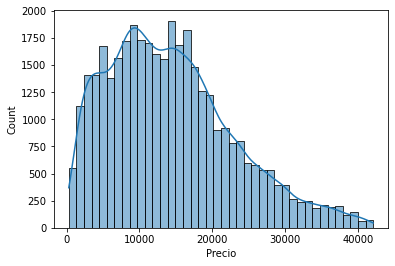

In [19]:
sns.histplot(data=df_filtrado, x="Precio", bins=40, kde=True)

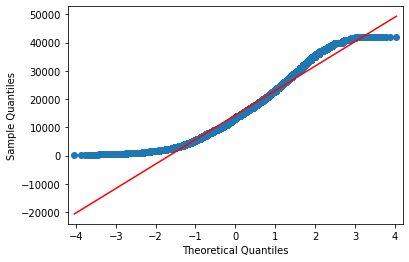

In [20]:
qqplot(df_filtrado.Precio , line='s');

In [21]:
stats.skew(df_filtrado.Precio)

0.6907707501006741

In [1]:
stat_fil, p_value_fil =stats.normaltest(df_filtrado.Precio)
if p_value_fil > 0.05:
    print(
        f'p_value = {p_value_fil}. Se acepta la hipótesis nula --> tenemos una distribución normal')
else:
    print(
        f'p_value = {p_value_fil}. Se rechaza la hipótesis nula --> no tenemos una distribución normal')

NameError: name 'stats' is not defined

# Vamos a ver de manera general la relación entre las variables

* Variables numéricas

In [23]:
df_filtrado.corr()

,Precio,Precio_financiado,Kilometros,Potencia
Precio,1.000000,0.724363,-0.612352,0.486610
Precio_financiado,0.724363,1.000000,-0.556149,0.233466
Kilometros,-0.612352,-0.556149,1.000000,0.079257
Potencia,0.486610,0.233466,0.079257,1.000000


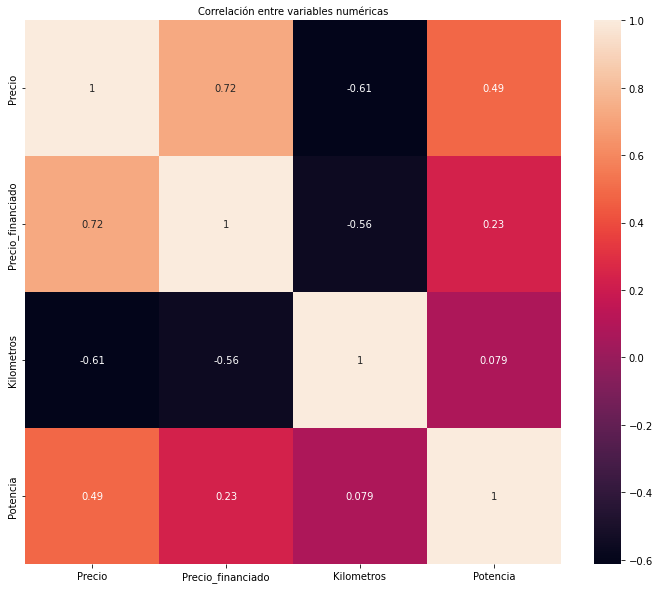

In [24]:
plt.figure(figsize=(12,10),facecolor='w');
plt.title('Correlación entre variables numéricas', fontsize=10);
sns.heatmap(df_filtrado.corr(),annot=True, facecolor='w');

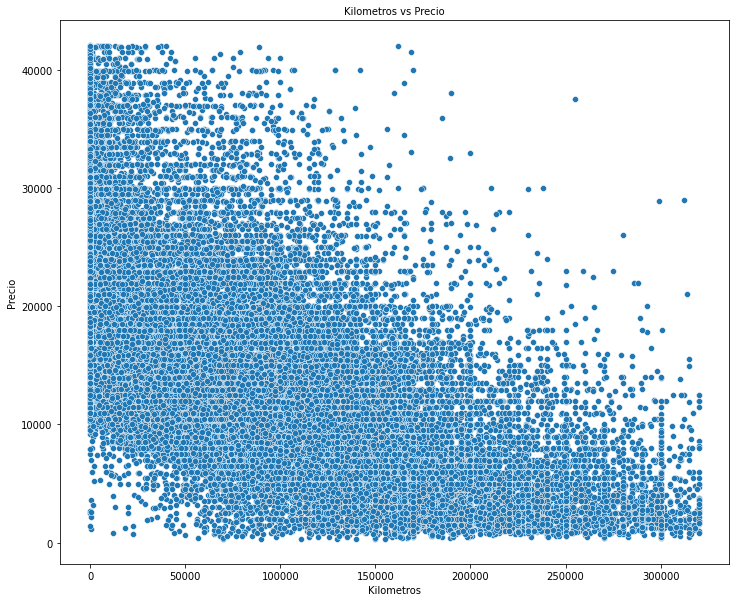

In [25]:
plt.figure(figsize=(12,10),facecolor='w');
plt.title('Kilometros vs Precio', fontsize=10);
sns.scatterplot(x=df_filtrado.Kilometros,y=df_filtrado.Precio);

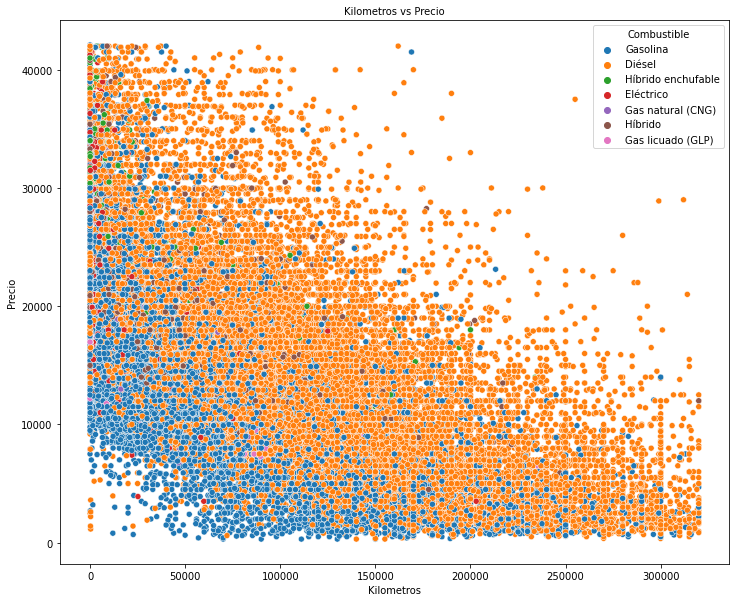

In [26]:
plt.figure(figsize=(12,10),facecolor='w');
plt.title('Kilometros vs Precio', fontsize=10);
sns.scatterplot(x=df_filtrado.Kilometros,y=df_filtrado.Precio, hue=df_filtrado.Combustible);

<AxesSubplot:title={'center':'Kilometros vs Precio'}, xlabel='Kilometros', ylabel='Precio'>

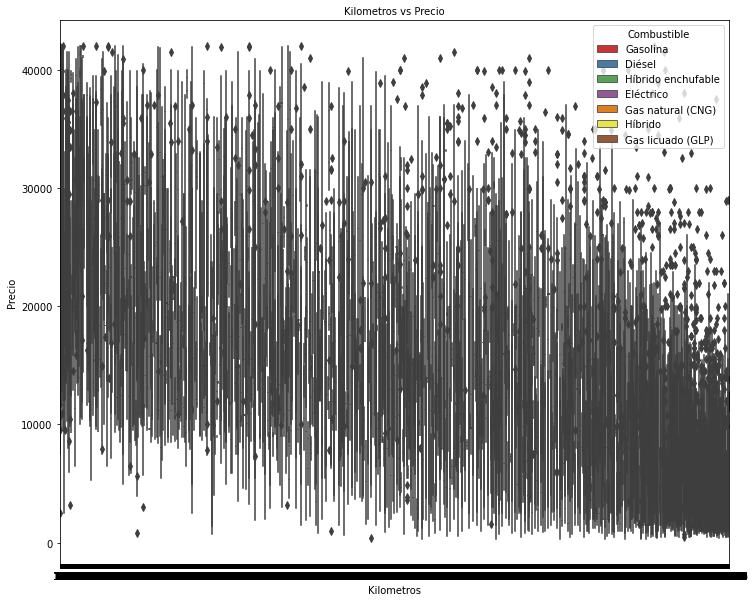

In [57]:
plt.figure(figsize=(12,10),facecolor='w');
plt.title('Kilometros vs Precio', fontsize=10);
# sns.scatterplot(x=df_filtrado.Kilometros,y=df_filtrado.Precio, hue=df_filtrado.Combustible);
sns.boxplot(x=df_filtrado.Kilometros, y=df_filtrado.Precio, hue=df_filtrado.Combustible, palette="Set1", width=0.5)

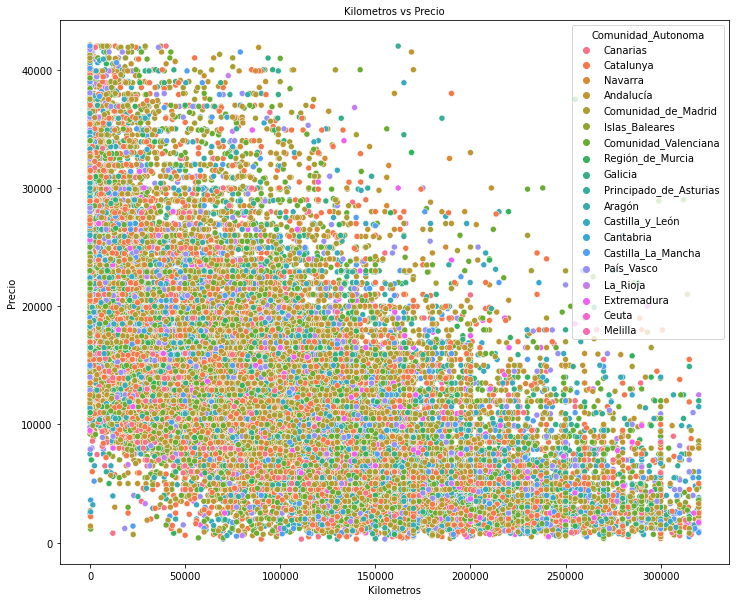

In [27]:
plt.figure(figsize=(12,10),facecolor='w');
plt.title('Kilometros vs Precio', fontsize=10);
sns.scatterplot(x=df_filtrado.Kilometros,y=df_filtrado.Precio, hue=df_filtrado.Comunidad_Autonoma);

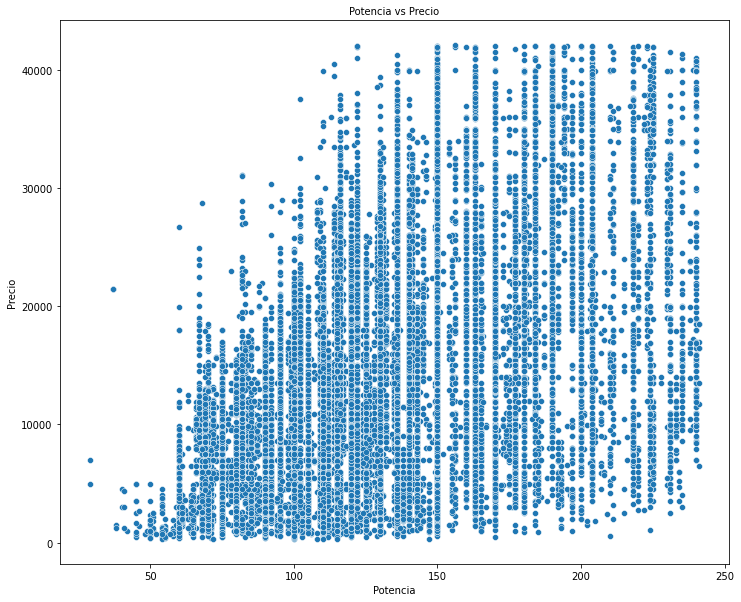

In [28]:
plt.figure(figsize=(12,10),facecolor='w');
plt.title('Potencia vs Precio', fontsize=10);
sns.scatterplot(x=df_filtrado.Potencia,y=df_filtrado.Precio);

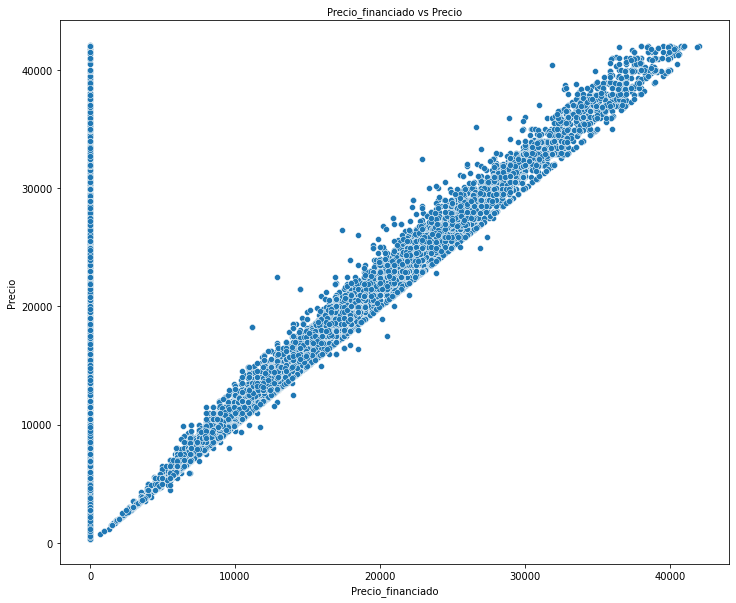

In [29]:
plt.figure(figsize=(12,10),facecolor='w');
plt.title('Precio_financiado vs Precio', fontsize=10);
sns.scatterplot(x=df_filtrado.Precio_financiado,y=df_filtrado.Precio);

In [30]:
df_filtrado.columns

Index(['Marca', 'Modelo', 'Version', 'Precio', 'Precio_financiado',
       'Combustible', 'Anyo', 'Kilometros', 'Potencia', 'Vendedor_profesional',
       'Vendedor', 'Provincia', 'Comunidad_Autonoma'],
      dtype='object')

In [31]:
num_var = ['Precio','Precio_financiado','Kilometros','Potencia']

In [32]:
cat_var = ['Marca','Modelo','Version','Combustible','Anyo','Vendedor_profesional','Vendedor','Provincia','Comunidad_Autonoma']

In [33]:
df_categorias = df_filtrado[cat_var]

In [34]:
df_categorias.columns

Index(['Marca', 'Modelo', 'Version', 'Combustible', 'Anyo',
       'Vendedor_profesional', 'Vendedor', 'Provincia', 'Comunidad_Autonoma'],
      dtype='object')

In [35]:
for i in range(len(df_categorias.columns)-1):
    for j in range(i+1,len(df_categorias.columns)):
        p_valor = stats.chi2_contingency(
            pd.DataFrame(pd.crosstab(
                df_categorias[df_categorias.columns[i]],df_categorias[df_categorias.columns[j]])))[1]
        if p_valor>0.05:
            print(f'hay independencia entre las columnas {df_categorias.columns[i]},{df_categorias.columns[j]}')

hay independencia entre las columnas Combustible,Vendedor


In [37]:
pd.crosstab(df_categorias.Combustible,df_categorias.Comunidad_Autonoma, margins=True )

Comunidad_Autonoma,Andalucía,Aragón,Canarias,Cantabria,Castilla_La_Mancha,Castilla_y_León,Catalunya,Ceuta,Comunidad_Valenciana,Comunidad_de_Madrid,Extremadura,Galicia,Islas_Baleares,La_Rioja,Melilla,Navarra,País_Vasco,Principado_de_Asturias,Región_de_Murcia,All
Combustible,,,,,,,,,,,,,,,,,,,,
Diésel,3993,663,441,276,896,1025,3424,5,2912,4787,516,1209,189,138,7,327,1141,355,593,22897
Eléctrico,45,14,9,3,19,34,86,0,47,133,9,25,4,1,0,3,32,13,12,489
Gas licuado (GLP),19,2,0,1,8,6,15,0,16,37,1,1,0,0,0,1,3,1,3,114
Gas natural (CNG),9,0,4,0,3,6,11,0,11,39,1,3,0,0,0,1,2,1,0,91
Gasolina,1649,326,707,111,338,557,2396,3,1716,2270,128,466,282,73,1,93,545,182,278,12121
Híbrido,129,35,24,7,21,64,184,0,82,321,14,65,3,8,0,13,50,20,29,1069
Híbrido enchufable,33,6,9,5,18,24,47,0,25,85,5,19,0,2,0,4,22,7,4,315
All,5877,1046,1194,403,1303,1716,6163,8,4809,7672,674,1788,478,222,8,442,1795,579,919,37096


El teorema del límite central: las medias de muestras grandes y aleatorias son aproximadamente normales

In [263]:
df_filtrado.columns

Index(['Marca', 'Modelo', 'Version', 'Precio', 'Precio_financiado',
       'Combustible', 'Anyo', 'Kilometros', 'Potencia', 'Vendedor_profesional',
       'Vendedor', 'Provincia', 'Comunidad_Autonoma'],
      dtype='object')

In [52]:
def teorema_central_limite(df_ref,cat,var):
    df_teorema = pd.DataFrame()
    for i in df_ref[cat].value_counts().index:
            df_teorema[f'{i}'] = np.array(
                [np.mean(df_ref[df_ref[cat]==i].sample(20)
                [var].values) for j in range(100 )])            
    # Ahora voy a comprar cada una de las columnas de ese nuevo dataframe
    dic_anova = {}
    for col in df_teorema.columns:
        dic_anova[col]=[]
        for idx in df_teorema.columns:
            valor = stats.f_oneway(df_teorema[col],df_teorema[idx])[1]
            if idx == col:
                dic_anova[col].append('X')
            elif valor > 0.05:
                dic_anova[col].append('Medias iguales')
            else:
                dic_anova[col].append('Distintas')
    df_anova =pd.DataFrame(dic_anova,index=df_teorema.columns)
    return df_anova

In [224]:
teorema_central_limite(df_filtrado,'Vendedor_profesional','Precio')

,True,False
True,X,Distintas
False,Distintas,X


In [225]:
teorema_central_limite((df[(df.Comunidad_Autonoma != 'Melilla')&(df.Comunidad_Autonoma != 'Ceuta')]),'Comunidad_Autonoma','Precio')

,Comunidad_de_Madrid,Catalunya,Andalucía,Comunidad_Valenciana,País_Vasco,Galicia,Castilla_y_León,Castilla_La_Mancha,Canarias,Aragón,Región_de_Murcia,Extremadura,Principado_de_Asturias,Islas_Baleares,Navarra,Cantabria,La_Rioja
Comunidad_de_Madrid,X,Medias iguales,Distintas,Medias iguales,Medias iguales,Medias iguales,Medias iguales,Distintas,Distintas,Distintas,Medias iguales,Distintas,Distintas,Distintas,Distintas,Medias iguales,Medias iguales
Catalunya,Medias iguales,X,Distintas,Distintas,Medias iguales,Medias iguales,Medias iguales,Distintas,Distintas,Distintas,Distintas,Distintas,Medias iguales,Distintas,Medias iguales,Distintas,Medias iguales
Andalucía,Distintas,Distintas,X,Medias iguales,Distintas,Distintas,Distintas,Medias iguales,Medias iguales,Medias iguales,Medias iguales,Distintas,Distintas,Medias iguales,Distintas,Medias iguales,Distintas
Comunidad_Valenciana,Medias iguales,Distintas,Medias iguales,X,Distintas,Medias iguales,Medias iguales,Distintas,Medias iguales,Distintas,Medias iguales,Distintas,Distintas,Distintas,Distintas,Medias iguales,Distintas
País_Vasco,Medias iguales,Medias iguales,Distintas,Distintas,X,Medias iguales,Medias iguales,Distintas,Distintas,Distintas,Distintas,Distintas,Medias iguales,Distintas,Medias iguales,Distintas,Medias iguales
Galicia,Medias iguales,Medias iguales,Distintas,Medias iguales,Medias iguales,X,Medias iguales,Distintas,Distintas,Distintas,Medias iguales,Distintas,Medias iguales,Distintas,Distintas,Distintas,Medias iguales
Castilla_y_León,Medias iguales,Medias iguales,Distintas,Medias iguales,Medias iguales,Medias iguales,X,Distintas,Distintas,Distintas,Medias iguales,Distintas,Distintas,Distintas,Distintas,Distintas,Medias iguales
Castilla_La_Mancha,Distintas,Distintas,Medias iguales,Distintas,Distintas,Distintas,Distintas,X,Medias iguales,Medias iguales,Distintas,Medias iguales,Distintas,Medias iguales,Distintas,Distintas,Distintas
Canarias,Distintas,Distintas,Medias iguales,Medias iguales,Distintas,Distintas,Distintas,Medias iguales,X,Medias iguales,Medias iguales,Medias iguales,Distintas,Medias iguales,Distintas,Medias iguales,Distintas
Aragón,Distintas,Distintas,Medias iguales,Distintas,Distintas,Distintas,Distintas,Medias iguales,Medias iguales,X,Distintas,Medias iguales,Distintas,Medias iguales,Distintas,Medias iguales,Distintas


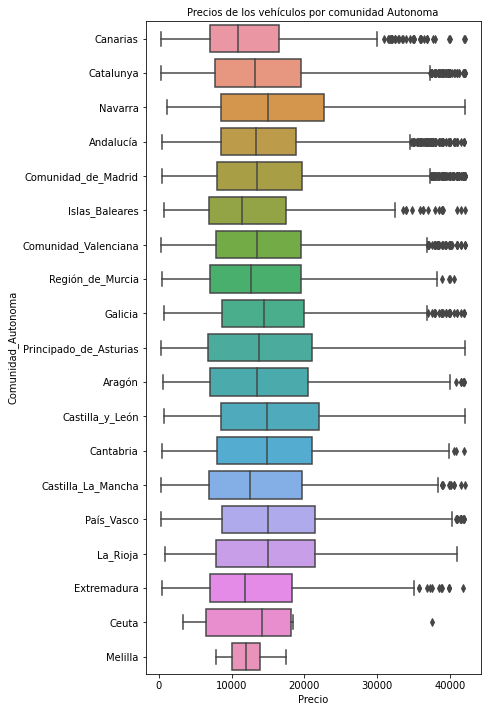

In [191]:
plt.figure(figsize=(6,12),facecolor='w');
plt.title('Precios de los vehículos por comunidad Autonoma', fontsize=10)
plt.ylabel('Comunidad Autonoma', fontsize=10)
plt.xlabel('Precio', fontsize=10)
sns.boxplot(y=df_filtrado.Comunidad_Autonoma, x=df_filtrado.Precio);

In [54]:
teorema_central_limite((df[(df.Comunidad_Autonoma != 'Melilla')&(df.Comunidad_Autonoma != 'Ceuta')]),'Comunidad_Autonoma','Kilometros')

,Comunidad_de_Madrid,Catalunya,Andalucía,Comunidad_Valenciana,País_Vasco,Galicia,Castilla_y_León,Castilla_La_Mancha,Canarias,Aragón,Región_de_Murcia,Extremadura,Principado_de_Asturias,Islas_Baleares,Navarra,Cantabria,La_Rioja
Comunidad_de_Madrid,X,Distintas,Medias iguales,Distintas,Distintas,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Medias iguales
Catalunya,Distintas,X,Distintas,Medias iguales,Medias iguales,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Medias iguales
Andalucía,Medias iguales,Distintas,X,Distintas,Distintas,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Medias iguales
Comunidad_Valenciana,Distintas,Medias iguales,Distintas,X,Medias iguales,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Medias iguales
País_Vasco,Distintas,Medias iguales,Distintas,Medias iguales,X,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas
Galicia,Distintas,Distintas,Distintas,Distintas,Distintas,X,Distintas,Distintas,Distintas,Medias iguales,Medias iguales,Distintas,Medias iguales,Distintas,Distintas,Distintas,Distintas
Castilla_y_León,Medias iguales,Distintas,Medias iguales,Distintas,Distintas,Distintas,X,Distintas,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Medias iguales
Castilla_La_Mancha,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,X,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Medias iguales,Distintas,Distintas
Canarias,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,X,Distintas,Distintas,Distintas,Distintas,Medias iguales,Distintas,Distintas,Distintas
Aragón,Medias iguales,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Medias iguales,Distintas,Distintas,X,Medias iguales,Distintas,Medias iguales,Distintas,Distintas,Medias iguales,Distintas


# Hipotesis los coches venididos por profesionales son más caros

In [80]:
profesionar_2 = profesional

In [87]:
stats.f_oneway(profesional,particular)[1]

3.859330415307577e-65

En la siguiente grafica se ve claramente como los vehículos 

<AxesSubplot:xlabel='Vendedor_profesional', ylabel='Precio'>

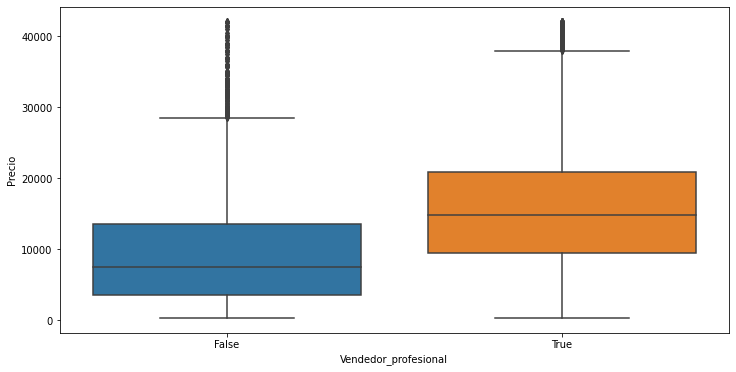

In [53]:
plt.figure(figsize=(12,6),facecolor='w')
sns.boxplot(x=df_filtrado.Vendedor_profesional, y=df_filtrado.Precio)

# Hipotesis la marca de coches más barata es Dacia

* Para oder hacer una buena valoración del precio de las marcas, voy a tener en cuenta solo las marcas que tengan a la venta un número de vehliculos considderable, he intentado filtrar por los outliers de numero de vehículos a la venta por marca, pero no me filtra por debajo, sale menor de 0

* Voy a filtrar por los outliers generales, para concretar más las marcas

In [20]:
df_precio_medio_marca = df_filtrado[['Marca','Precio']].groupby(
    by=["Marca"],axis=0).mean()

In [21]:
df_precio_medio_marca[
    df_precio_medio_marca ==  df_precio_medio_marca.min()]

,Precio
Marca,
ABARTH,NaN
ALFA ROMEO,NaN
AUDI,NaN
BMW,NaN
CADILLAC,NaN
CHEVROLET,NaN
CHRYSLER,NaN
CITROEN,NaN
CUPRA,NaN


Teniendo en cuenta todas las marcas, incluso las que venden muy pocos vehículos, la marca de coches más barata sería **DAEWOO** con una media de precio de 1431€

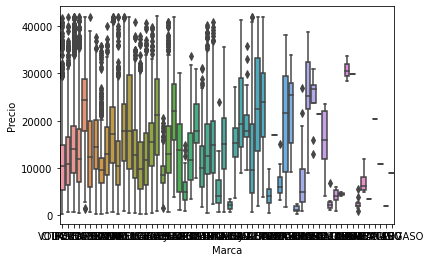

In [154]:
sns.boxplot(x='Marca', y='Precio', data=df_filtrado)
plt.show()

In [188]:
marcas_filtradas = df_filtrado.Marca.value_counts()[
    df_filtrado.Marca.value_counts() > 100].index

In [189]:
df_precio_medio_marca_filtro = df_filtrado[['Marca','Precio']][
    df_filtrado.Marca.isin(marcas_filtradas)].groupby(
        by=["Marca"]).mean()

In [190]:
df_precio_medio_marca_filtro[
    df_precio_medio_marca_filtro == df_precio_medio_marca_filtro.min()]

,Precio
Marca,
ALFA ROMEO,NaN
AUDI,NaN
BMW,NaN
CHEVROLET,5503.258503
CITROEN,NaN
DACIA,NaN
DS,NaN
FIAT,NaN
FORD,NaN


Si filtramos por las marcas que tienen más de 100 vehículos a la venta, la marca más barata sería **CHEVROLET** con un precio medio de 5503€

# Comunidad con más vehículos a la venta es Catalunya

In [62]:
tabla_num_ventas_com = pd.crosstab(
    index=df.Comunidad_Autonoma,columns='Numero_Ventas')

In [72]:
tabla_num_ventas_com

col_0,Numero_Ventas
Comunidad_Autonoma,
Andalucía,6472
Aragón,1135
Canarias,1311
Cantabria,436
Castilla_La_Mancha,1441
Castilla_y_León,1949
Catalunya,6947
Ceuta,8
Comunidad_Valenciana,5337


La comunidad con más vehículos a la venta es la Comunidad de Madrid

# Hipotesis los coches Híbridos son más caros que los Diesel

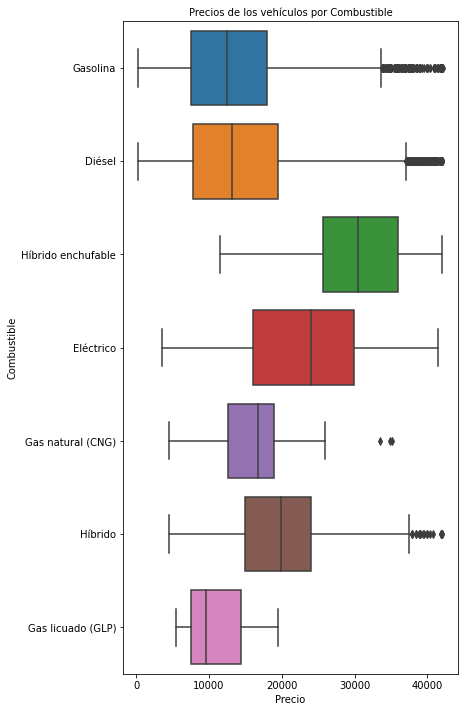

In [226]:
plt.figure(figsize=(6,12),facecolor='w');
plt.title('Precios de los vehículos por Combustible', fontsize=10)
plt.ylabel('Combustible', fontsize=10)
plt.xlabel('Precio', fontsize=10)
sns.boxplot(y=df_filtrado.Combustible, x=df_filtrado.Precio);

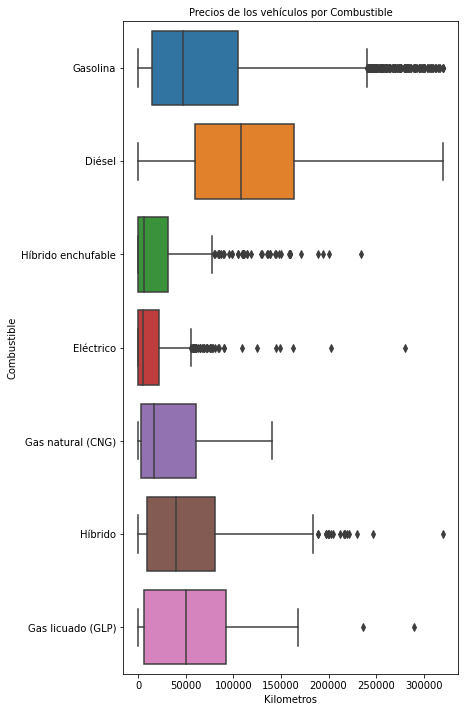

In [55]:
plt.figure(figsize=(6,12),facecolor='w');
plt.title('Precios de los vehículos por Combustible', fontsize=10)
plt.ylabel('Combustible', fontsize=10)
plt.xlabel('Precio', fontsize=10)
sns.boxplot(y=df_filtrado.Combustible, x=df_filtrado.Kilometros);

In [227]:
teorema_central_limite(df_filtrado,'Combustible','Precio')

,Diésel,Gasolina,Híbrido,Eléctrico,Híbrido enchufable,Gas licuado (GLP),Gas natural (CNG)
Diésel,X,Distintas,Distintas,Distintas,Distintas,Distintas,Distintas
Gasolina,Distintas,X,Distintas,Distintas,Distintas,Distintas,Distintas
Híbrido,Distintas,Distintas,X,Distintas,Distintas,Distintas,Distintas
Eléctrico,Distintas,Distintas,Distintas,X,Distintas,Distintas,Distintas
Híbrido enchufable,Distintas,Distintas,Distintas,Distintas,X,Distintas,Distintas
Gas licuado (GLP),Distintas,Distintas,Distintas,Distintas,Distintas,X,Distintas
Gas natural (CNG),Distintas,Distintas,Distintas,Distintas,Distintas,Distintas,X


In [191]:
df_filtrado.Combustible.value_counts()

Diésel                22744
Gasolina              11727
Híbrido                1069
Eléctrico               489
Híbrido enchufable      315
Gas licuado (GLP)       114
Gas natural (CNG)        91
Name: Combustible, dtype: int64

In [194]:
df_filtrado.Combustible = df_filtrado.Combustible.str.replace(' ','_')

C:\Users\saula\AppData\Local\Temp\ipykernel_16028\2100234746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.Combustible = df_filtrado.Combustible.str.replace(' ','_')


In [195]:
df_filtrado.Combustible.value_counts()

Diésel                22744
Gasolina              11727
Híbrido                1069
Eléctrico               489
Híbrido_enchufable      315
Gas_licuado_(GLP)       114
Gas_natural_(CNG)        91
Name: Combustible, dtype: int64

In [198]:
df_precio_medio_Combustible = df_filtrado[['Combustible','Precio','Anyo','Kilometros']].groupby(
        by=["Combustible"]).mean()

In [199]:
df_precio_medio_Combustible

,Precio,Anyo,Kilometros
Combustible,,,
Diésel,14407.648743,2013.605918,114881.625572
Eléctrico,23318.578732,2018.413088,16907.554192
Gas_licuado_(GLP),10758.342105,2017.929825,57325.166667
Gas_natural_(CNG),15591.241758,2018.318681,34569.637363
Gasolina,13356.410761,2014.706148,65198.313806
Híbrido,20309.293732,2017.525725,50943.310571
Híbrido_enchufable,30181.720635,2018.749206,27374.755556


En la tabla podemos ver que el precio medio de los Diesel es bastante menor que el precio de los Hibridos (enchufables y no echufables) pero también vemos la la antigüedad y los kilometros de los vehículos diesel es mucho mayor que la de los vehículos Híbridos. Para poder confirmar la hipótesis vamos a filtrar los vehículos diesel en el rango de kms y anyos en los que se encuentran los Híbridos.

In [201]:
df_hibridos = df_filtrado[(df_filtrado.Combustible == 'Híbrido')|(df_filtrado.Combustible == 'Híbrido_enchufable')]

In [202]:
df_hibridos.describe()

,Precio,Precio_financiado,Anyo,Kilometros,Potencia
count,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000
mean,22556.269509,17394.229046,2017.804191,45579.080202,157.796243
std,8214.561739,10919.141564,2.307825,49422.738337,41.089189
min,4499.000000,0.000000,2007.000000,0.000000,70.000000
25%,16277.500000,11747.500000,2016.000000,3787.500000,125.000000
50%,21435.000000,18295.000000,2018.000000,29040.500000,141.000000
75%,28462.500000,24900.000000,2020.000000,75000.000000,197.000000
max,42000.000000,41990.000000,2021.000000,320000.000000,240.000000


In [203]:
filtro_hibridos = (df_filtrado.Anyo > 2016) & (df_filtrado.Kilometros < 100000) & (df_filtrado.Potencia < 197)

In [204]:
df_filtro_hibridos = df_filtrado[filtro_hibridos]

In [205]:
df_precio_medio_Combustible_V2 = df_filtro_hibridos[['Combustible','Precio','Anyo','Kilometros']].groupby(
        by=["Combustible"]).mean()

In [206]:
df_precio_medio_Combustible_V2

,Precio,Anyo,Kilometros
Combustible,,,
Diésel,21847.664137,2018.302600,37350.327144
Eléctrico,24976.045070,2019.250704,7836.842254
Gas_licuado_(GLP),11703.081395,2018.569767,34589.755814
Gas_natural_(CNG),16764.278481,2018.835443,22637.177215
Gasolina,17491.675218,2018.803638,22892.607898
Híbrido,21554.098569,2018.810811,25574.658188
Híbrido_enchufable,29686.735632,2019.873563,3758.908046


Cuando filtramos los datos por los anyos, kilometros y potencia de los vehículos híbridos (más restrictivos que los diesel) la tabla muestra que los vehículos Diesel son más caros que los hibridos y más baratos que los híbridos enchufables

In [224]:
hibridos = df_filtro_hibridos.Precio[df_filtro_hibridos.Combustible == 'Híbrido']

In [226]:
hibridos_ench = df_filtro_hibridos.Precio[df_filtro_hibridos.Combustible == 'Híbrido_enchufable']

In [225]:
gasolina = df_filtro_hibridos.Precio[df_filtro_hibridos.Combustible == 'Gasolina']

In [227]:
diesel = df_filtro_hibridos.Precio[df_filtro_hibridos.Combustible == 'Diésel']

In [230]:
diesel_V2 = diesel

$$ H_0 = \mu_m=\mu_E..\\
H_1 = \mu_i \neq mu_j $$

In [215]:
import matplotlib.pyplot as plt
import scipy.stats as ss

In [241]:
ss.f_oneway(hibridos,diesel)

F_onewayResult(statistic=0.8553361709348386, pvalue=0.3550798525907676)

Como el p_valor es mayor que 0.05, se acepta la hipotesis nula, lo que quiere decir que la media de precios de los hibridos es la misma que la media de precios de los diesel

Media de precios por comunidades_autonomas

In [242]:
df_precio_medio_com = df_filtrado[['Comunidad_Autonoma','Precio']].groupby(
        by=["Comunidad_Autonoma"]).mean()

In [243]:
df_precio_medio_com

,Precio
Comunidad_Autonoma,
Andalucía,14296.209830
Aragón,14575.478049
Canarias,12536.290569
Cantabria,15224.343358
Castilla_La_Mancha,13941.807874
Castilla_y_León,15754.552836
Catalunya,14338.838917
Ceuta,14587.500000
Comunidad_Valenciana,14339.291395


In [244]:
df_filtrado.Comunidad_Autonoma.value_counts().index

Index(['Comunidad_de_Madrid', 'Catalunya', 'Andalucía', 'Comunidad_Valenciana',
       'País_Vasco', 'Galicia', 'Castilla_y_León', 'Castilla_La_Mancha',
       'Canarias', 'Aragón', 'Región_de_Murcia', 'Extremadura',
       'Principado_de_Asturias', 'Islas_Baleares', 'Navarra', 'Cantabria',
       'La_Rioja', 'Ceuta', 'Melilla'],
      dtype='object')

In [249]:
dic_com = {}
for com in df_filtrado.Comunidad_Autonoma.value_counts().index:
    dic_com[com] = [df_filtrado.Precio[
        df_filtrado.Comunidad_Autonoma == com].values]

In [256]:
# anova_com = pd.DataFrame()
# for idx,k in enumerate(dic_com.keys()):
#     anova_com[k] = ss.f_oneway()
    

0 Comunidad_de_Madrid
1 Catalunya
2 Andalucía
3 Comunidad_Valenciana
4 País_Vasco
5 Galicia
6 Castilla_y_León
7 Castilla_La_Mancha
8 Canarias
9 Aragón
10 Región_de_Murcia
11 Extremadura
12 Principado_de_Asturias
13 Islas_Baleares
14 Navarra
15 Cantabria
16 La_Rioja
17 Ceuta
18 Melilla


In [253]:
dic_com['Catalunya']

[array([ 7851,  8200,  6300, ..., 30900, 19490,  2790], dtype=int64)]

In [254]:
ss.f_oneway(dic_com['Comunidad_de_Madrid'][0],dic_com['Catalunya'][0])

F_onewayResult(statistic=3.0824096413916613, pvalue=0.0791656166602514)

In [257]:
from scipy import stats

In [258]:
stats.shapiro(df_filtrado.Precio)

C:\Users\saula\miniconda3\envs\the_bridge_22\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9596183896064758, pvalue=0.0)

In [262]:
stats.normaltest(df_filtrado.Precio)

NormaltestResult(statistic=2398.088262165494, pvalue=0.0)

<AxesSubplot:xlabel='Precio', ylabel='Count'>

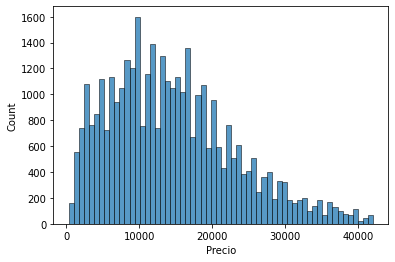

In [264]:
sns.histplot(data=df_filtrado, x="Precio")

<AxesSubplot:xlabel='Kilometros', ylabel='Precio'>

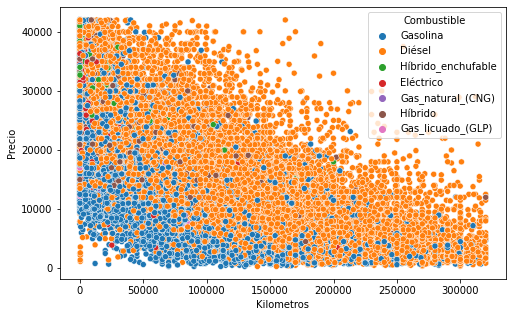

In [269]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Kilometros", y="Precio",  hue="Combustible", data=df_filtrado)

In [266]:
df_filtrado.corr()

,Precio,Precio_financiado,Anyo,Kilometros,Potencia,Vendedor_profesional
Precio,1.000000,0.721773,0.684393,-0.609931,0.488997,0.301864
Precio_financiado,0.721773,1.000000,0.605143,-0.553248,0.232863,0.496670
Anyo,0.684393,0.605143,1.000000,-0.778711,-0.006704,0.455634
Kilometros,-0.609931,-0.553248,-0.778711,1.000000,0.083836,-0.365584
Potencia,0.488997,0.232863,-0.006704,0.083836,1.000000,-0.048832
Vendedor_profesional,0.301864,0.496670,0.455634,-0.365584,-0.048832,1.000000


<AxesSubplot:xlabel='Anyo', ylabel='Precio'>

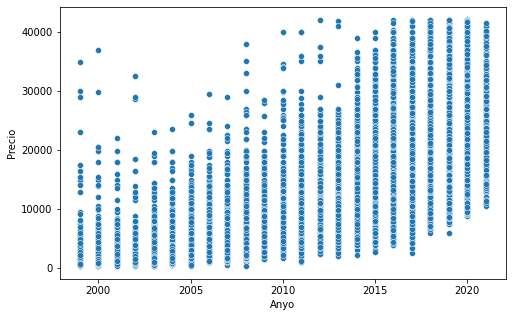

In [267]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="Anyo", y="Precio", data=df_filtrado)

C:\Users\saula\miniconda3\envs\the_bridge_22\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Precio'>

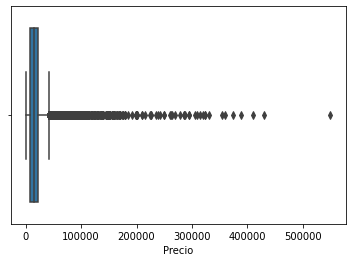

In [272]:
sns.boxplot(df.Precio)

C:\Users\saula\miniconda3\envs\the_bridge_22\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Precio'>

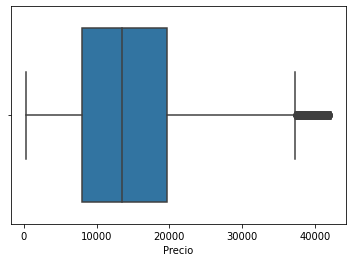

In [273]:
sns.boxplot(df_filtrado.Precio)

<AxesSubplot:>

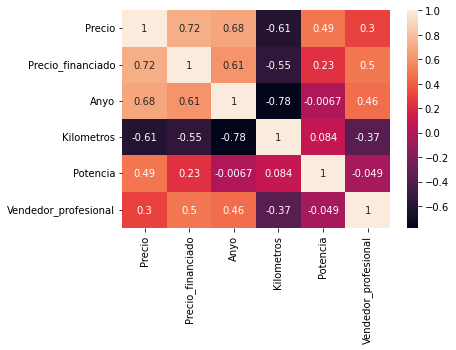

In [277]:
sns.heatmap(df_filtrado.corr(),annot=True, facecolor='w')